In [3]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = (x_test.astype(np.float32) - 127.5)/127.5
mnist_data=x_test.reshape(10000, 784)
print(mnist_data.shape)
len(mnist_data)

11501568/11490434 [==============================] - 0s 0us/step
(10000, 784)


10000

In [5]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=784, activation='tanh'))
    return generator

g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 559,632
Trainable params: 559,632
Non-trainable params: 0
_________________________________________________________________


In [6]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=512,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=1, activation='sigmoid'))    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator

d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [7]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               559632    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 1,093,137
Trainable params: 559,632
Non-trainable params: 533,505
_________________________________________________________________


In [8]:
def plot_generated_images(generator):
    noise = np.random.normal(loc=0, scale=1, size=[100, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

100%|██████████| 5000/5000 [06:33<00:00, 12.70it/s]


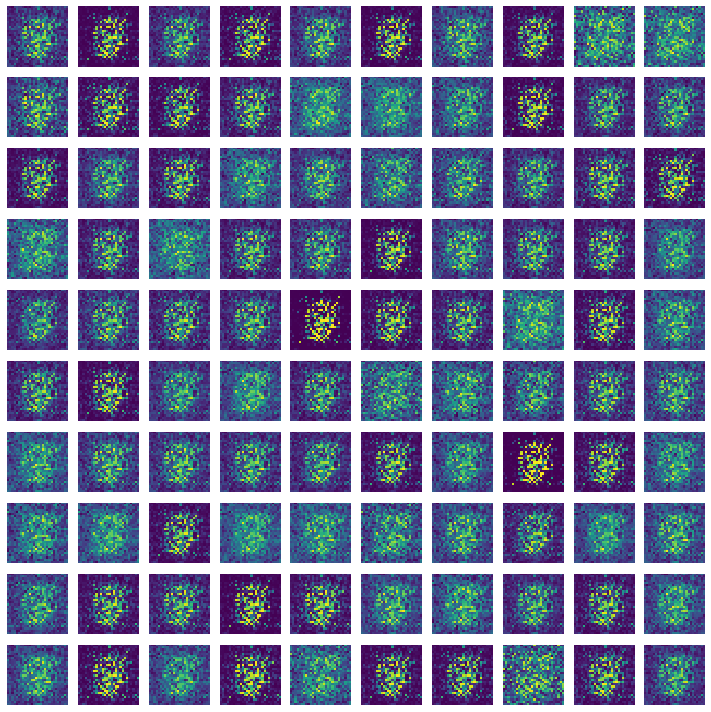

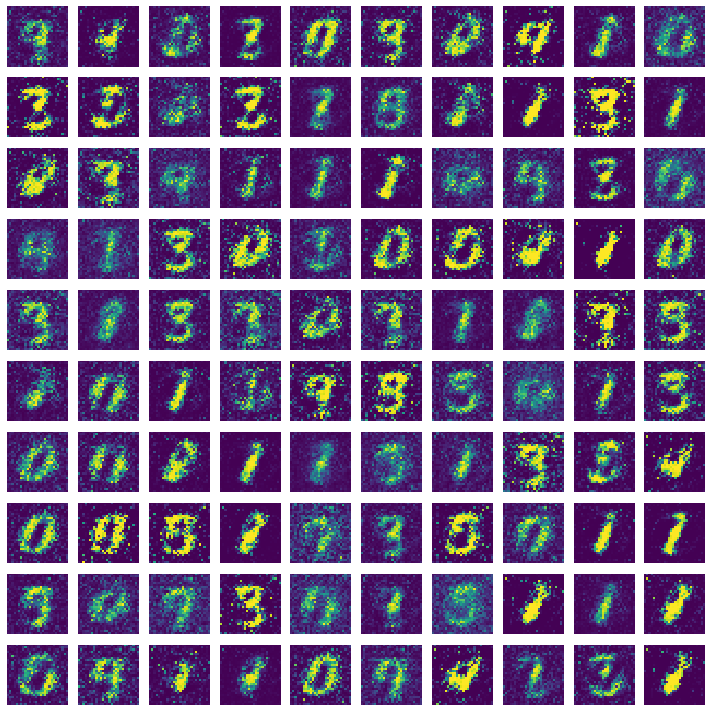

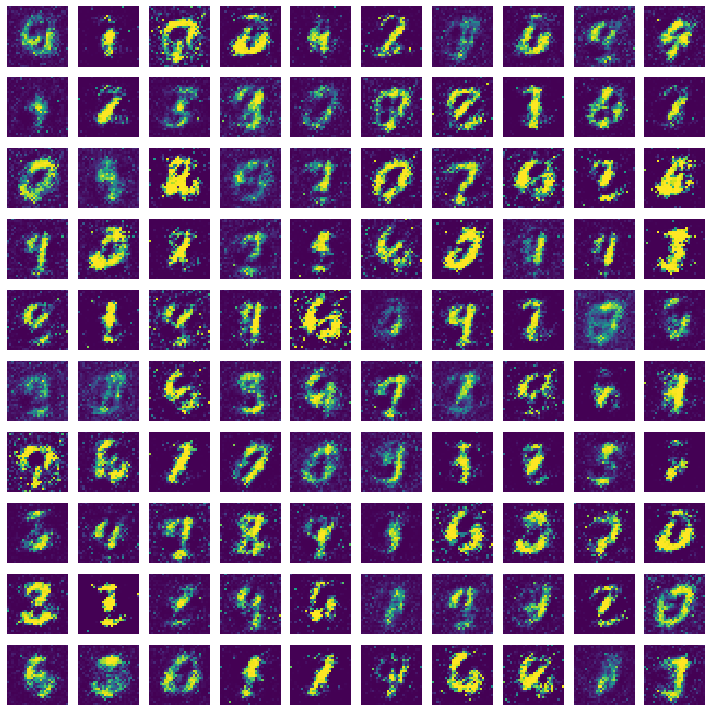

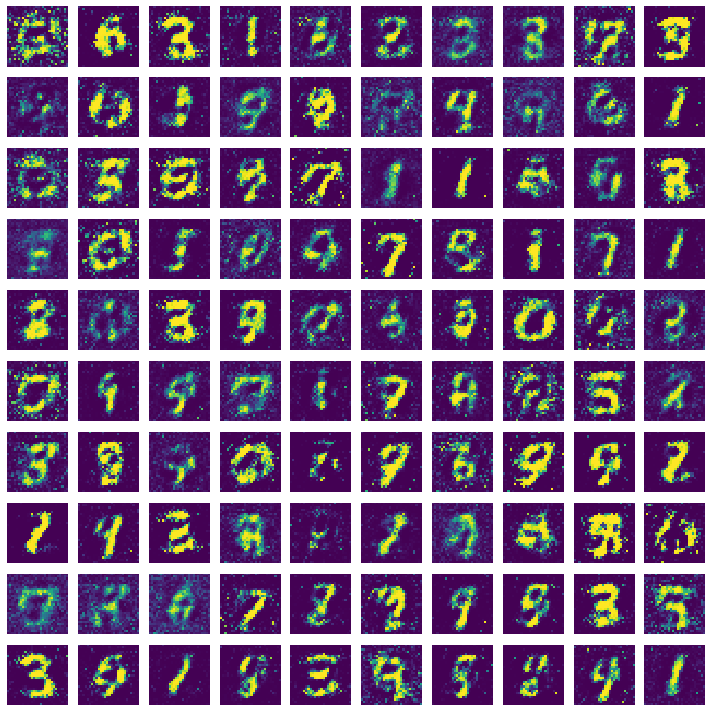

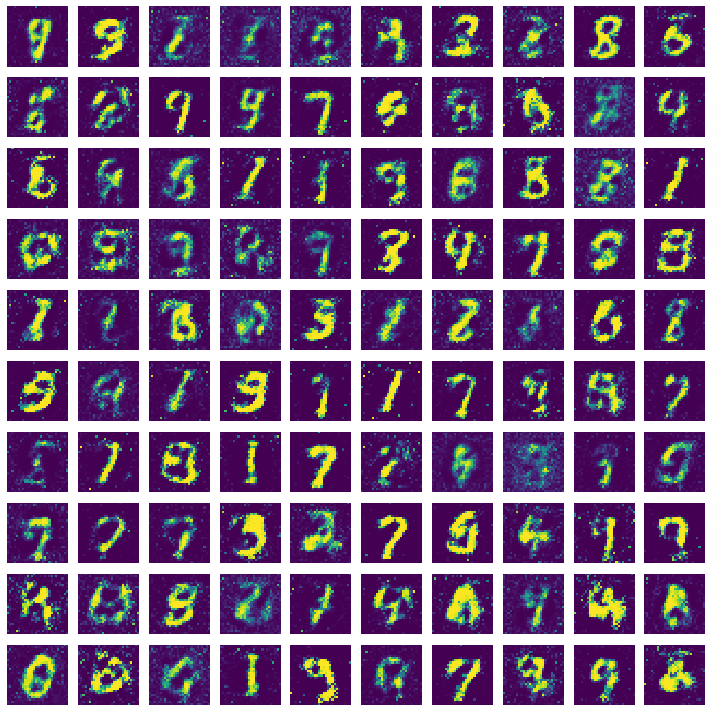

In [10]:
batch_size = 128
epochs = 5000

for e in tqdm(range(epochs)):
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images=g.predict(noise)
    image_batch=mnist_data[np.random.randint(low=0,high=mnist_data.shape[0],size=batch_size)]
    X = np.concatenate([image_batch, generated_images])
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 1

    d.trainable = True
    d.train_on_batch(X, y_dis)

    noise = np.random.normal(0,1, [batch_size, 100])
    y_gen = np.ones(batch_size)
    d.trainable = False
    gan.train_on_batch(noise, y_gen)
    
    if e == 0 or e % 1000 == 0:    
        plot_generated_images(g)